Student Name: AKHIL RAGHU NATH

Student ID: 23048417

# Activity 6: Pytorch and CNNs for Fashion-MNIST

In this activity, we are going to explore designing various neural networks for the FashionMNIST classification problem. This is, of course, a 'toy' problem, but the fundamentals of classification of images is here.


## Hints, tips, and notes

* Here I'm not going to mandate TensorBoard. In Colab, this is a little bit more involved. Instead, we'll just put the losses and accuracies in a list and print them after training. However, TensorBoard is very useful, particularly for projects, so I suggest playing around with it.
* Some of these runs will take several minutes to complete. This is the nature of ML. Grab a beer, or a coffee.

As usual, we will give you some code that you use to build the rest of the activity.

# Common Code

All the imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import models

### 1. Select the device to use.

To access the GPU on Google Colab, `Select Runtime` -> `Change Runtime Type` and pick `GPU` from the `Hardware Accelerator` dropdown menu. In the free version, the GPU is modest. If you buy credits, you get access to a much nice A100 GPU. In both cases, you may find contention for the resource is an issue, but less likely to happen if you use credits.

In [2]:
# Get appropriate device for training
device = ( "cuda"     # CUDA is a programming interface for certain Nvidia GPUs
           if torch.cuda.is_available()
           else "mps"  # Kind of like CUDA for a mac, I guess? I don't use macs
           if torch.backends.mps.is_available()
           else "cpu" )   # If you end up with CPU, go use Google Colab and get a GPU

print(f"{device} device available")

cuda device available


### 2. Code for training the models

I'm going to provide this code, rather than you having to struggle creating it. This is a normal training cycle with PyTorch. However, I do want you to explain the PyTorch functions called in the train function. I will marke them with comments.

In [3]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        #<--- what is this function for?

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   #<--- this is a bit funny, explain it

        # Compute prediction error
        pred = model(X)                     #<--- what is this for?
        loss = loss_fn(pred, y)             #<--- what is this for?

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()                     #<--- what is this for?
        optimizer.step()                    #<--- what is this for?
        optimizer.zero_grad()               #<--- what is this for?

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy



### <font color='red'>Your input here.</font>
<font color='red'>Enter you description of the above parts:</font>



1.model.train()----- this method is used to set the model in training mode, it activates certain layers like Batch Normalization to behave as intended during the training process.

2.X, y = X.to(device), y.to(device): ---this will pass the input data(X) and target labels(y) to the specified device(GPU/CPU).

3.pred = model(X) --- computing the predicted outputs by passing the input data X through the model.The model processes the input data and generates predictions for the given input samples.

4.loss = loss_fn(pred, y)  ---calculate the loss between the predicted outputs and the actual targets labels.The loss_fn is a predefined loss function (e.g., CrossEntropyLoss, Mean Squared Error) that computes the discrepancy between predictions and actual targets.

5.loss.backward() ----this initiates the backpropogation and calculates the gradients of the loss function.Gradients represent the slope of the loss function with respect to each parameter and are necessary for updating the weights during optimization

6.optimizer.step() -----this will update the model's parameters based on the gradients (computed using loss.backward() above) using the optimization algorithm (like SGD, Adam)  in the direction that minimizes the loss.

7.optimizer.zero_grad()----this resets the gradients of all parameters in the model and prevents gradient accumulation across iterations which can lead to incorrect gradient updates if not cleared before the next iteration

### 3. Load the data

1. Load the Fashion-MNIST dataset using `torchvision`'s `datasets` library (e.g., [`datasets.FashionMNIST...`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)...)
2. When loading the data, convert it to tensor format ([`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)), and apply the standard scaler to the data (using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Use the [`transforms.Resize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform to turn it into a 28x28 image rather than a 784-vector
    * Rather than loading the data, and caluclating the mean and std, you can use the values `mean = 0.2859` and `std = 0.3530`. I pre-calculated these for you!
3. Create the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. Here we're going to use a batch size of 64.
4. Display a few examples of the dataset - this is always a good idea to make sure the data has loaded correctly

We haven't really touched on batch size yet, because up to now we have used plain old gradient descent. Later on, we will use the Adam optimiser, because it is quicker and uses less memory. But Adam is a mini-batch optimizer, and you have to pick that mini-batch size. Bit more info on this, if you are interested:
 * https://sebastianraschka.com/faq/docs/gradient-optimization.html
 * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

We need to set the batch size when we create the dataloaders.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

100%|██████████| 26421880/26421880 [00:02<00:00, 10402387.37it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 177090.17it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3172283.42it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6488064.00it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Ankle boot   Shirt   Shirt   Trouser   Sneaker   Pullover   Sneaker   Pullover


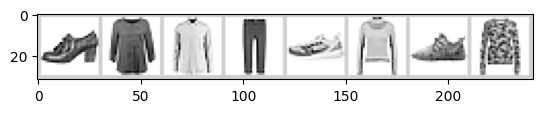

In [4]:
##############################
# Your code below
import torchvision
import numpy as np


# the mean and std values for normalization
mean = 0.2859
std = 0.3530

# transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.ToTensor(),        # Convert to Tensor
    transforms.Normalize(mean, std)  # Normalize using the above defined mean and std
])

# Loading Fashion-MNIST dataset with transformations
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Creating DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Displaying a few examples from the dataset
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Function to show images
def matplotlib_imshow(image,one_channel=False):
  if one_channel:
    image=image.mean(dim=0)
  image = image / 2 + 0.5
  npimg = image.numpy ()
  if one_channel:
    plt.imshow(npimg , cmap= "Greys")
  else:
    plt.imshow (np.transpose(npimg, (1, 2, 0)))

# random training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()
images = images[:8]
labels = labels[:8]
img_grid=torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid,one_channel=True)
print('   '.join(classes[labels[j]]for j in range(8)))



---
## 1. Replicate the Neural Network from the previous tasks for the FashionMNIST dataset
---


In the previous activity, you designed a fully connected neural network (a multi-layer perceptron) to predict on Fashion-MNIST.

1. Replicate the best network that you found in that activity, but in PyTorch.
1. Use [`summary`](https://pypi.org/project/torch-summary/) to display a summary of your model.
1. Use some random inputs to test the model. This will be meaningless, as the model is not trained yet (and the inputs are random). However, it is useful to test that you have defined the model at leats without any coding errors.

Hints and notes:
 * We need to [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the incoming data. In the previous step, you loaded the dataset as a 28x28 image (because, later on we will be using CNNs that require image inputs). However, fully connected layers require vector inputs. `nn.Flatten` converts the image input to a vector (i.e., a 28x28 image to a 784 vector).
 * Use [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to "send" objects to the GPU (if you have one). E.g., once you define your class for the neural network, you will create an instance of that NN - you need to send this object to the GPU.
 * Generally, at inference time, we will use a [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) on the output of the model. Prior to the softmax, the model outputs a score per class. That is, there will be 10 outputs. However, here we will ignore the softmax part.


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

Best network in last assignment was single layer of 300 giving 89% (not given in question, i randomly chosen 300 as width in that)and 3 hidden layer of (100,100,50) with 88.88%. Here i am using (100,100,50)

In [ ]:
##############################
# Your code below


# Defining model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()  # Flatten the input
        self._stack_=nn.Sequential(     # sequential stack ( used this approach as demonstrated  by professor in lab)
            nn.Linear(28 * 28, 100),# First hidden layer with 100 units
            nn.ReLU(),
            nn.Linear(100, 100),# Second hidden layer with 100 units
            nn.ReLU(),
            nn.Linear(100, 50),# Third hidden layer with 50 units
            nn.ReLU(),
            nn.Linear(50, 10)# Output layer with 10 classes
        )
    def forward(self, x):
        x = self.flatten(x)
        x = self._stack_(x)
        return x

# Creating an instance of the model
model = NeuralNetwork().to(device)

# Print the model summary
summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 50]           5,050
              ReLU-7                   [-1, 50]               0
            Linear-8                   [-1, 10]             510
Total params: 94,160
Trainable params: 94,160
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.36
Estimated Total Size (MB): 0.37
----------------------------------------------------------------


Now train the model.

We will use [Cross Entropy Loss](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e), and as discussed, the Adam optimiser (with learning rate = 0.001).

* Call the training loop - I would suggest a max of ~20 epochs
* Use matplotlib to plot the train and test loss, and the train and test accuracy
* Describe what you see in the graphs

This training could take a few minutes. But note how you will see a bunch of losses reported in each epoch? These are the mini-batches in Adam that we discussed before. Then there will be an overall Train and Test error reported for the Epoch.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 20
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model,loss_fn, optimizer, epochs)


Epoch 1:

loss: 2.323907  [   64/60000]
loss: 0.761700  [ 6464/60000]
loss: 0.617112  [12864/60000]
loss: 0.513278  [19264/60000]
loss: 0.371315  [25664/60000]
loss: 0.570157  [32064/60000]
loss: 0.442087  [38464/60000]
loss: 0.283633  [44864/60000]
loss: 0.332241  [51264/60000]
loss: 0.509571  [57664/60000]
Train Error: 
 Accuracy: 86.8%, Avg loss: 0.370031 

Test Error: 
 Accuracy: 85.3%, Avg loss: 0.410654 

Epoch 2:

loss: 0.549871  [   64/60000]
loss: 0.214345  [ 6464/60000]
loss: 0.319125  [12864/60000]
loss: 0.264035  [19264/60000]
loss: 0.202719  [25664/60000]
loss: 0.444423  [32064/60000]
loss: 0.328417  [38464/60000]
loss: 0.353884  [44864/60000]
loss: 0.344711  [51264/60000]
loss: 0.598352  [57664/60000]
Train Error: 
 Accuracy: 87.7%, Avg loss: 0.335167 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.389557 

Epoch 3:

loss: 0.363416  [   64/60000]
loss: 0.423877  [ 6464/60000]
loss: 0.299353  [12864/60000]
loss: 0.599909  [19264/60000]
loss: 0.410542  [25664/60000]
loss: 0.36

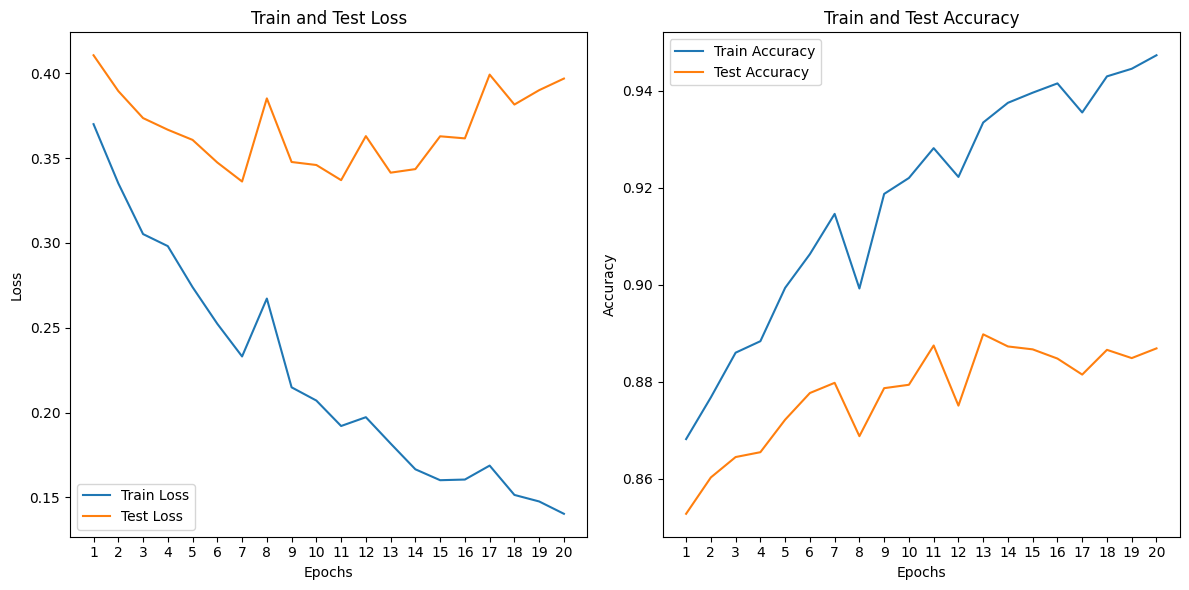

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))

# Plotting train and test loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss")
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss")
plt.xticks(range(1, epochs + 1))
plt.legend()



# Plotting train and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1),train_accuracy, label='Train Accuracy')
plt.plot(range(1, epochs + 1),test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()

The training loss is reducing over the epochs and train accuracy is increasing over the epoch,this means model is learning well to fit the training data  and correctly classifying samples within the training data. While in testing,loss is decreasing  upto epoch 7 ( means initially improving its prediction) and then fluctuates and goes higher side,means failing to generalise unseen data.The train accuracy is 94.7% and test accuracy is 88.7%, and there is a significant gap in test loss and train loss,these gap between performance matrices indicates overfitting.


---

# 2. Replicate LeNet-5 for Fashion-MNIST

---


Below is the LeNet architecture (from https://en.wikipedia.org/wiki/LeNet). If you search on the internet, you will find slightly different implementations and descriptions of LeNet-5, but below is what was actually in LeCun's [original paper](https://ieeexplore.ieee.org/document/726791). Of course, LeCun was applying this to the digit recognition problem (MNIST), but we are looking at Fashion-MNIST.

 * Create the model in PyTorch.
 * Train the model using the same parameters as above, and plot the loss and accuracy.
 * Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?

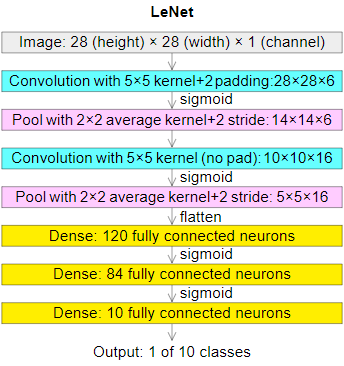

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
#Defining LeNet model
class LeNet5 (nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.lenet_stack_=nn.Sequential(
         nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2), #padding is 2 as per above figure
         nn.Sigmoid(),
         nn.AvgPool2d(2, 2),
         nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
         nn.Sigmoid(),
         nn.AvgPool2d(2, 2),
         nn.Flatten(),
         nn.Linear(16*5*5, 120),
         nn.Sigmoid(),
         nn.Linear(120, 84),
         nn.Sigmoid(),
         nn.Linear(84, 10),
     )
  def forward(self, x):
    logits = self.lenet_stack_(x)
    return logits

#model to GPU
model_1 = LeNet5().to(device)

# Print the model summary
summary(model_1, (1, 28, 28))

# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-3)
#training loop
epochs = 20
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model_1,loss_fn, optimizer, epochs)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
           Sigmoid-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
           Sigmoid-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

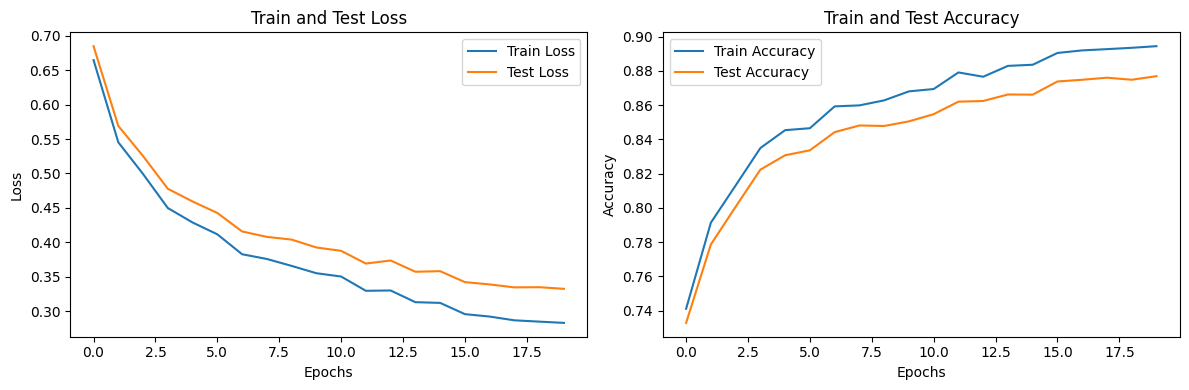

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))

# Plotting train and test loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plotting train and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

As you seen in the above graph LeNet has test and train accuracy is nearer and loss is also reducing over the eoch in test and train.It means model is well generalized without overfitting. The Fully connected model above shows overfitting as we discussed.By comapring, the parameter in fully connected model is 94160 and in LeNet is 61706,and also LeNet is using Convolution which may be effective in extract feature. We can say that with fewer parameter and using convolution Lenet is generalizing the data well without overfiting than fully connected model above.The higher parameter count in the Fully Connected model might lead to increased model complexity, potentially contributing to overfitting. However the train accuracy  is more in fully connected model and test accuracy also is marginally ahead of LeNet model.

---
# 3. Modernise LeNet
---


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

* Update LeNet with these newer functions.
* Train using the same parameters as above.
* Compare and discuss with the above using the normal discussion criteria


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>



In modern lenet ReLu activation function is used instead of Sigmoid and Maxpool is used instead of Average pool.

In [ ]:
#Defining model
class ModernLeNet5 (nn.Module):
 def __init__(self):
    super(ModernLeNet5, self).__init__()
    self.Modern_lenet_stack_=nn.Sequential(
         nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
         nn.ReLU(), #using ReLu instead of simoid
         nn.MaxPool2d(2,2),  #using MaxPool instead of AveragePool
         nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
         nn.ReLU(),
         nn.MaxPool2d(2, 2),
         nn.Flatten(),
         nn.Linear(16*5*5, 120),
         nn.ReLU(),
         nn.Linear(120, 84),
         nn.ReLU(),
         nn.Linear(84, 10),
     )


 def forward(self, x):
    logits = self.Modern_lenet_stack_(x)
    return logits

#model(mode2) to GPU
model2 = ModernLeNet5().to(device)

# Print the model summary
summary(model2, (1, 28, 28))

# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

epochs = 20
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model2,loss_fn, optimizer, epochs)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

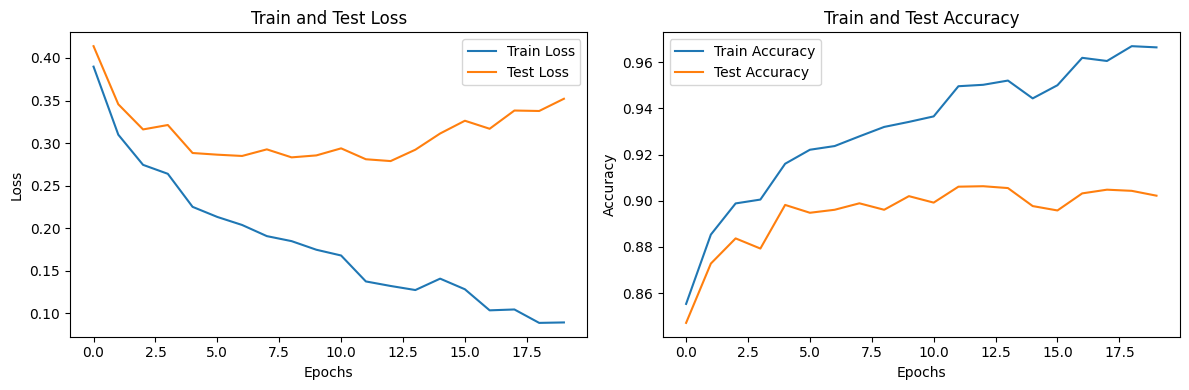

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))

# Plotting train and test loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plotting train and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

In modernised Lenet we used above the accuracy is increased in both test and train cases.And train loss is reduced to 0.10 as compared with 0.28 in old LeNet model. This suggests that changes like replacing Sigmoid activation with ReLU and using Max Pooling instead of Average Pooling have improved the model's performance. But in train loss its almost same and it is showing a significant gap between test and train matrix in the accuracies, which means overfitting is happening. The widening gap between training and testing losses are clear indications of the model's inability to generalize well on unseen data, which was not  in old LeNet Model.

---
# 4. Build your own CNN model
---

Build your own classifier model - see can you break 90% accuracy. You can use LeNet as a basis if you like.

With some networks I built, I could get 93 to 94% test accuracy.

Some hints:
 * not every convolutional layer needs a pooling layer afterwards
 * Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)
 * But don't just bung loads of layers in there - you will end up overfitting badly
 * Use a [batchnorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) after each convolutional layer. You get decent performance gains without adding many parameters
 * Don't be afraid to get to a million or two parameters
 * Have a look on Google to see what others are doing (you're going to do this anyway, right?). Don't just copy them, though, try to understand.

Explain what you did that improved things for the classification and why they improved things.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
#defining model
class new_model_LeNet(nn.Module):
    def __init__(self):
        super(new_model_LeNet, self).__init__()
        self.new_model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10)
         )

    def forward(self, x):
        x = self.new_model(x)
        return x

#model(mode2) to GPU
model_new = new_model_LeNet().to(device)

# Print the model summary
summary(model_new, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
         MaxPool2d-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          18,496
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
        MaxPool2d-11             [-1, 64, 7, 7]               0
          Flatten-12                 [-1, 3136]               0
           Linear-13                  [-1, 512]       1,606,144
      BatchNorm1d-14                  [

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_new.parameters(), lr=1e-3)

epochs = 20
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model_new,loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.364415  [   64/60000]
loss: 0.353115  [ 6464/60000]
loss: 0.440893  [12864/60000]
loss: 0.291621  [19264/60000]
loss: 0.184975  [25664/60000]
loss: 0.363713  [32064/60000]
loss: 0.368961  [38464/60000]
loss: 0.329566  [44864/60000]
loss: 0.289588  [51264/60000]
loss: 0.422349  [57664/60000]
Train Error: 
 Accuracy: 91.6%, Avg loss: 0.223507 

Test Error: 
 Accuracy: 90.1%, Avg loss: 0.278568 

Epoch 2:

loss: 0.214525  [   64/60000]
loss: 0.192655  [ 6464/60000]
loss: 0.253268  [12864/60000]
loss: 0.134782  [19264/60000]
loss: 0.255079  [25664/60000]
loss: 0.142979  [32064/60000]
loss: 0.208669  [38464/60000]
loss: 0.119133  [44864/60000]
loss: 0.288257  [51264/60000]
loss: 0.189535  [57664/60000]
Train Error: 
 Accuracy: 95.1%, Avg loss: 0.138661 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.214914 

Epoch 3:

loss: 0.125663  [   64/60000]
loss: 0.170795  [ 6464/60000]
loss: 0.210298  [12864/60000]
loss: 0.132607  [19264/60000]
loss: 0.158923  [25664/60000]
loss: 0.15

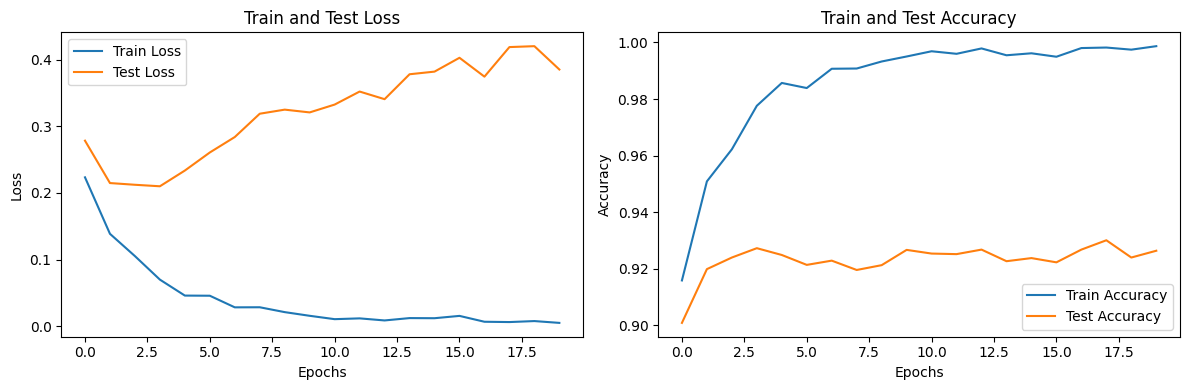

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))

# Plotting train and test loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plotting train and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

I have taken the Modernised Lenet as basis and made some changes in it. Added more convolution layer (with 16, 32, and 64 filters and uses two 3*3 kernel) increases the depth and may have the chances to extract features more efficiently and thinking it may lead to better performance.BatchNorm was done at after every covolution ( batch Norm take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer) to improve convergence and generalization.Total Parameters were 1635818 .Test accuracy has been increased to 92.4%.Train loss was almost null. But significant gap in test and train metrics shows overfitting.Tried implementing Dropout , but no improvement was noted so removed it.The lack of improvement with dropout may be attributed to the higher parameter count in the model. Generally, a model with an increased number of parameters has the potential to predict well from the training data, resulting in low training loss but poor generalization, thus causing higher test loss due to overfitting.

---
# 5. Transfer Learning
---

Nobody trains large models from scratch. Rather, they use large pretrained models, that have been trained perhaps for weeks on very large datasets. Then, we can tweak the model for our needs. This allows us to use large models on small datasets and (hopefully) avoid some overfitting.

We are going to load ResNet18, we're going to cut the head off it - in this case, we will replace the very last layer. ResNet18 was trained for 1000 classes, we only have 10.

Do the following:
1. From `torchvision.models`, load [`ResNet18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.
1. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.
1. Freeze all but the last layer of your adapted ResNet model, and retrain.
1. Provide some commentary on the three approaches. Particularly, what's the difference between all three approaches we outlined here?

For the freezing of layers, the following article is useful:
https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In step 3 above, we may see that the network doesn't necessarily perform as well as previous networks, in terms of test accuracy. Probably we should unfreeze more of the later layers to allow better fine-tuning of the network to our problem. And there are more complicated and powerful finetuning strategies out there. But you should see that overfitting is, more or less, solved. This is because we are only training a much smaller number of parameters, and freezing all of the convolution layers in the ResNet.


In [ ]:
# We need to recreate the dataloaders, because ResNet expects a three channel
# RGB input, whereas FashionMNIST only has 1 channel (greyscale). Use
# `transforms.Grayscale(3)` to replicated the grayscale image into the three
# channels.

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

batch_size = 64
# Recreate the data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

Approach 1.From torchvision.models, load ResNet18, and use random weights (weights=None). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.


In [ ]:
# Define the loss function and the optimizer
resnet18_rndm_weights = torchvision.models.resnet18(weights=None)  # Use random weights
num_classes = 10
resnet18_rndm_weights.fc = nn.Linear(resnet18_rndm_weights.fc.in_features, num_classes)  # Replace fully connected layer for 10 classes
#model to GPU
model_resnet = resnet18_rndm_weights.to(device)

#print the summary of the model
summary(model_resnet,(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

Ellipsis

In [ ]:
##############################
# Your code below
# Define the loss function and the optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=1e-3)
epochs = 20
train_loss1, train_accuracy1, test_loss1, test_accuracy1 = train_loop(train_dataloader, test_dataloader, model_resnet, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.434888  [   64/60000]
loss: 0.531769  [ 6464/60000]
loss: 0.384983  [12864/60000]
loss: 0.496285  [19264/60000]
loss: 0.606548  [25664/60000]
loss: 0.430922  [32064/60000]
loss: 0.283316  [38464/60000]
loss: 0.482343  [44864/60000]
loss: 0.336716  [51264/60000]
loss: 0.367366  [57664/60000]
Train Error: 
 Accuracy: 84.8%, Avg loss: 0.391588 

Test Error: 
 Accuracy: 83.4%, Avg loss: 0.430104 

Epoch 2:

loss: 0.329130  [   64/60000]
loss: 0.300333  [ 6464/60000]
loss: 0.263686  [12864/60000]
loss: 0.321215  [19264/60000]
loss: 0.286218  [25664/60000]
loss: 0.344328  [32064/60000]
loss: 0.270059  [38464/60000]
loss: 0.405676  [44864/60000]
loss: 0.281832  [51264/60000]
loss: 0.354064  [57664/60000]
Train Error: 
 Accuracy: 86.7%, Avg loss: 0.340436 

Test Error: 
 Accuracy: 85.3%, Avg loss: 0.382990 

Epoch 3:

loss: 0.265342  [   64/60000]
loss: 0.241675  [ 6464/60000]
loss: 0.225175  [12864/60000]
loss: 0.286746  [19264/60000]
loss: 0.284618  [25664/60000]
loss: 0.35

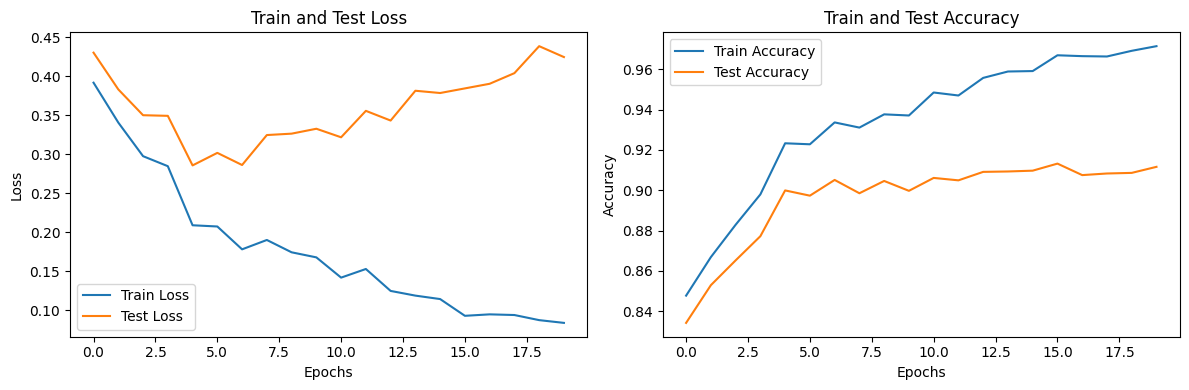

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))

# Plotting train and test loss
plt.subplot(1, 2, 1)
plt.plot(train_loss1, label='Train Loss')
plt.plot(test_loss1, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plotting train and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy1, label='Train Accuracy')
plt.plot(test_accuracy1, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Approach 2. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.


In [ ]:
resnet18_default = torchvision.models.resnet18()  # Use default parameter
num_classes = 10
resnet18_default.fc = nn.Linear(resnet18_default.fc.in_features, num_classes)  # Replace fully connected layer for 10 classes
model_resnet_default = resnet18_default.to(device)
summary(model_resnet_default,(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [ ]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet_default.parameters(), lr=1e-3)
epochs = 20
train_loss2, train_accuracy2, test_loss2, test_accuracy2 = train_loop(train_dataloader, test_dataloader, model_resnet_default, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.504116  [   64/60000]
loss: 0.523146  [ 6464/60000]
loss: 0.374673  [12864/60000]
loss: 0.465788  [19264/60000]
loss: 0.598359  [25664/60000]
loss: 0.474905  [32064/60000]
loss: 0.337741  [38464/60000]
loss: 0.516781  [44864/60000]
loss: 0.317135  [51264/60000]
loss: 0.417001  [57664/60000]
Train Error: 
 Accuracy: 84.2%, Avg loss: 0.396668 

Test Error: 
 Accuracy: 82.2%, Avg loss: 0.441301 

Epoch 2:

loss: 0.329501  [   64/60000]
loss: 0.366613  [ 6464/60000]
loss: 0.270509  [12864/60000]
loss: 0.294108  [19264/60000]
loss: 0.361391  [25664/60000]
loss: 0.357555  [32064/60000]
loss: 0.223332  [38464/60000]
loss: 0.407831  [44864/60000]
loss: 0.269188  [51264/60000]
loss: 0.272131  [57664/60000]
Train Error: 
 Accuracy: 87.1%, Avg loss: 0.329209 

Test Error: 
 Accuracy: 85.7%, Avg loss: 0.383109 

Epoch 3:

loss: 0.208936  [   64/60000]
loss: 0.273045  [ 6464/60000]
loss: 0.209875  [12864/60000]
loss: 0.228155  [19264/60000]
loss: 0.278027  [25664/60000]
loss: 0.35

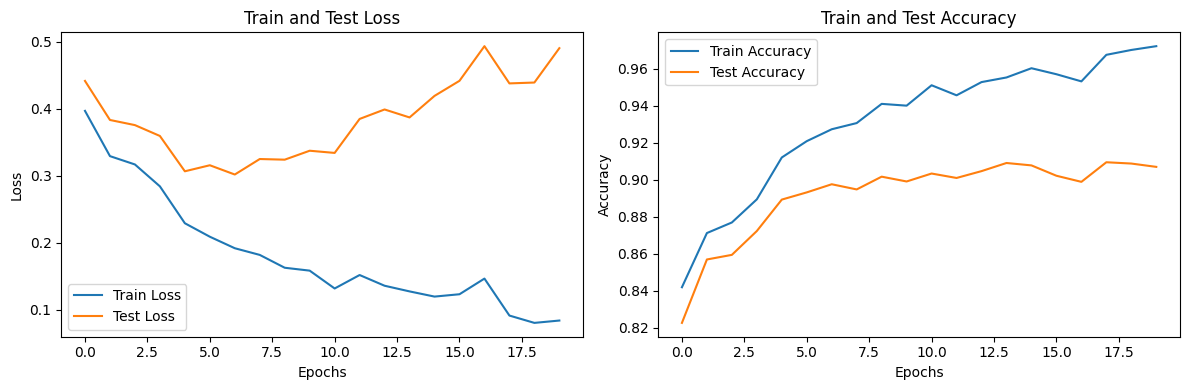

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))

# Plotting train and test loss
plt.subplot(1, 2, 1)
plt.plot(train_loss2, label='Train Loss')
plt.plot(test_loss2, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plotting train and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy2, label='Train Accuracy')
plt.plot(test_accuracy2, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Approach 3 . Freeze all but the last layer of your adapted ResNet model, and retrain.

In [ ]:
resnet18_freeze = torchvision.models.resnet18()  # Use default parameter
num_classes = 10
resnet18_freeze.fc = nn.Linear(resnet18_freeze.fc.in_features, num_classes)  # Replace fully connected layer for 10 classes

#freesing layers
for parameter in resnet18_freeze.parameters():
    parameter.requires_grad = False        # freeze all layers
for parameter in resnet18_freeze.fc.parameters():
    parameter.requires_grad = True    # unfreeze the last layer

#model to device
model_resnet_freeze = resnet18_freeze.to(device)
#print the summary
summary(model_resnet_freeze,(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [ ]:
#define loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet_freeze.parameters(), lr=1e-3)
epochs = 20
train_loss3, train_accuracy3, test_loss3, test_accuracy3 = train_loop(train_dataloader, test_dataloader, model_resnet_freeze, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.661262  [   64/60000]
loss: 1.314023  [ 6464/60000]
loss: 0.752912  [12864/60000]
loss: 1.189340  [19264/60000]
loss: 0.896578  [25664/60000]
loss: 0.793464  [32064/60000]
loss: 0.680790  [38464/60000]
loss: 0.845332  [44864/60000]
loss: 0.877719  [51264/60000]
loss: 0.744074  [57664/60000]
Train Error: 
 Accuracy: 74.9%, Avg loss: 0.723018 

Test Error: 
 Accuracy: 73.9%, Avg loss: 0.756313 

Epoch 2:

loss: 0.755678  [   64/60000]
loss: 0.933934  [ 6464/60000]
loss: 0.564522  [12864/60000]
loss: 1.028169  [19264/60000]
loss: 0.881859  [25664/60000]
loss: 0.693210  [32064/60000]
loss: 0.609508  [38464/60000]
loss: 0.826412  [44864/60000]
loss: 0.831565  [51264/60000]
loss: 0.720538  [57664/60000]
Train Error: 
 Accuracy: 75.8%, Avg loss: 0.686727 

Test Error: 
 Accuracy: 74.3%, Avg loss: 0.729890 

Epoch 3:

loss: 0.723983  [   64/60000]
loss: 0.906388  [ 6464/60000]
loss: 0.540341  [12864/60000]
loss: 0.980952  [19264/60000]
loss: 0.884709  [25664/60000]
loss: 0.65

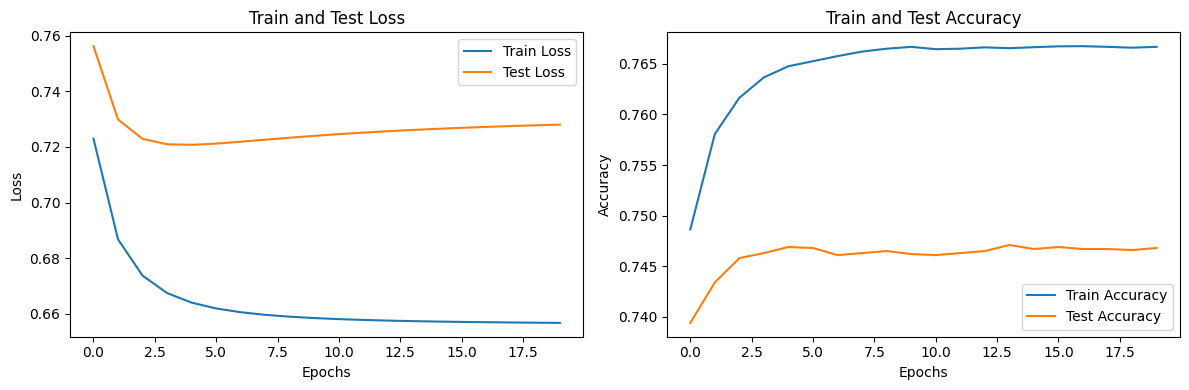

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))

# Plotting train and test loss
plt.subplot(1, 2, 1)
plt.plot(train_loss3, label='Train Loss')
plt.plot(test_loss3, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plotting train and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy3, label='Train Accuracy')
plt.plot(test_accuracy3, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

First one starts with random weights for all layers, Second approach mostly uses pre-trained weights except for the last layer adjusted for our task, and Approach 3 utilizes pre-trained weights like second approach. . Unlike Approaches 1 and 2, which will train entire layer, Approach 3  we are freezing all layer ( it learns on only prior learned features )and modifies only the last layer , so we can say that Approach 3 is more computationally effective by altering fewer parameters during training ,while Approach 1 and 2 require updating all or most of the network's parameters. To compare accuracy and loss i have plot the 3 approaches graph together below(in same scale -easy to compare). In that we can see that approach 1 has more accuracy 91.2% than approach 2 (90.9%) and in case of Approach 3 we have very less accuracy of (72.8%) in Test data(unseen data).Loss also more in approach 3.Eventhough accuracy is less the overfitting which was evident in Approach 1 and 2 was reduced in Approach 3. As said by Professor ,in approach 3, unfreezing some more layer and with fine-tuning  we may can balance overfitting with improved the accuracy and minimalization of loss.

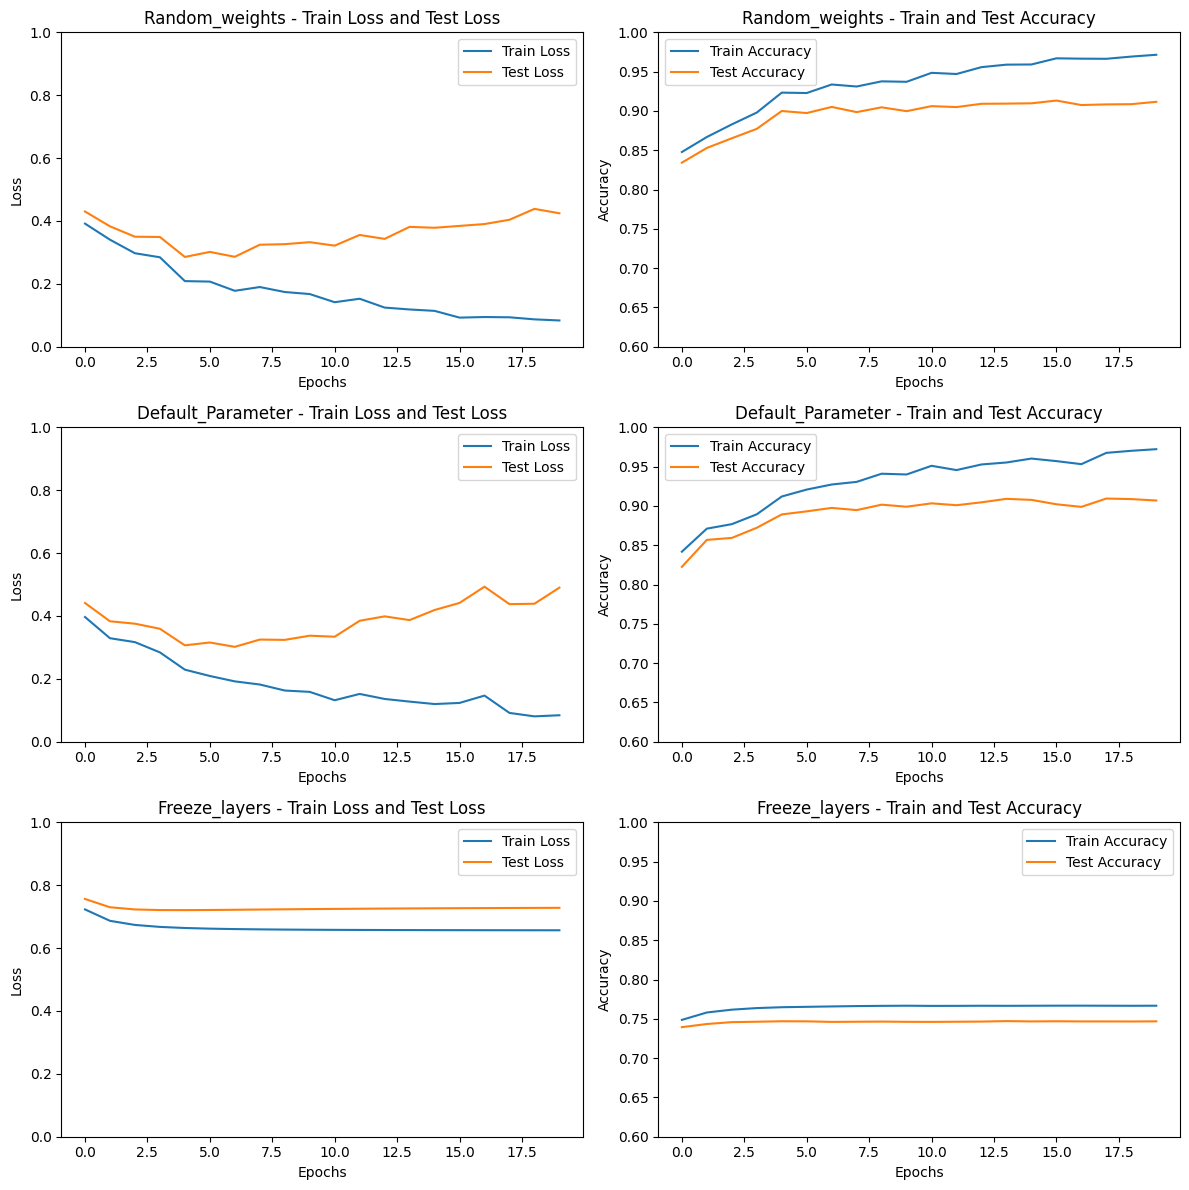

In [ ]:

train_losses = [train_loss1, train_loss2, train_loss3]
train_accuracies = [train_accuracy1, train_accuracy2, train_accuracy3]
test_losses = [test_loss1, test_loss2, test_loss3]
test_accuracies = [test_accuracy1, test_accuracy2, test_accuracy3]
titles=['Random_weights','Default_Parameter','Freeze_layers']

num_sets = len(train_losses)
plt.figure(figsize=(12, 12))

for i in range(0,3):
    # Plotting train and test loss
    plt.subplot(3, 2, i*2 + 1)
    plt.plot(train_losses[i], label='Train Loss')
    plt.plot(test_losses[i], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{titles[i]} - Train Loss and Test Loss')
    plt.legend()
    plt.ylim(0.0, 1.0)  # Set y-axis limits for loss

    # Plotting train and test accuracy
    plt.subplot(3, 2, i*2 + 2)
    plt.plot(train_accuracies[i], label='Train Accuracy')
    plt.plot(test_accuracies[i], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{titles[i]} - Train and Test Accuracy')
    plt.legend()
    plt.ylim(0.6, 1.0)  # Set y-axis limits for accuracy

plt.tight_layout()
plt.show()
